In [1]:
import numpy as np
import pandas as pd 
import altair as alt
import re 
from commons import data_processing
from commons import common_objects as co
import matplotlib.pyplot as plt
from venn import venn
from scipy import stats, signal
from matplotlib_venn import venn2
import warnings

warnings.filterwarnings('ignore')
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [2]:
pgc = data_processing.get_files(r'./data/DIA', exts=['PGC.tsv'])[0]
rplc = data_processing.get_files(r'./data/DIA/', exts=['RPLC.tsv'])[0]


In [3]:
files = [rplc, pgc]
columns = ['RPLC', 'PGC']

df = pd.DataFrame()

for (col, file) in zip(columns, files):
    print(col, file)
    _df = pd.read_csv(file, delimiter='\t')
    _df.loc[:, 'column'] = col 
    _df.loc[:, 'sample'] = _df.Run.map(lambda x: x.split('_')[-3])
    _df.loc[:, 'tech_rep'] = _df.Run.map(lambda x: x.split('_')[-1])

    df = pd.concat([df, _df])
    df.reset_index(inplace=True, drop=True)

RPLC ./data/DIA/RPLC\T10.MT10_RPLC.tsv
PGC ./data/DIA\PGC\T10.MT10_PGC.tsv


In [ ]:
g = df.groupby(['sample', 'column', 'Modified.Sequence']).mean()
g = g.reset_index()

total = alt.Chart(g).mark_area(
    opacity=0.6
).transform_density(
    'RT',
    as_=['RT', 'density'],
    groupby=['sample', 'column']
).encode(
    x=alt.X('RT:Q', title='Retention Time',
        axis=co.alt_axis),
    y=alt.Y('density:Q', title='',
        axis=co.alt_axis),
    color=column_colors,
    row='sample:N'
).properties(
    height=150,
    width=400,
    title='Total'
)

unique = alt.Chart(g.drop_duplicates('Modified.Sequence',keep=False)).mark_area(
    opacity=0.6
).transform_density(
    'RT',
    as_=['RT', 'density'],
    groupby=['sample', 'column']
).encode(
    x=alt.X('RT:Q', title='Retention Time',
        axis=co.alt_axis),
    y=alt.Y('density:Q', title='',
        axis=co.alt_axis),
    color=column_colors,
    row='sample:N'
).properties(
    height=150,
    width=400,
    title='Unique'
)

total | unique

In [4]:
from modlamp.descriptors import PeptideDescriptor

def pour(seq, scale='gravy'):
    desc = PeptideDescriptor(seq, scale)
    desc.calculate_global()
    return desc.descriptor[0][0]


def accessory(seq, scale='polarity'):
    desc = PeptideDescriptor(seq, scale)
    desc.calculate_global()
    return desc.descriptor[0][0]


In [5]:
time = df.groupby(['column', 'Modified.Sequence', 'Stripped.Sequence']).mean()
time = time.reset_index()

time.loc[:, 'length'] = time['Stripped.Sequence'].map(lambda x: len(x))
time.loc[:, 'gravy'] = time['Stripped.Sequence'].map(pour)
time.loc[:, 'polarity'] = time['Stripped.Sequence'].map(accessory)


counts = time['Modified.Sequence'].value_counts()
valid = counts[counts.values==2].keys()
time = time[time['Modified.Sequence'].isin(valid)]


data_difference = pd.DataFrame()

for seq, s_frame in data_processing.iterate_contents('Modified.Sequence', time, get_item=True):
    length = s_frame.length.mean()
    gravy = s_frame.gravy.mean()
    polarity = s_frame.polarity.mean()
    stripped = s_frame['Stripped.Sequence'].values[0]
    t_diff = s_frame[['Modified.Sequence', 'RT']].groupby('Modified.Sequence').diff(periods=-1).values[0]
    # display(s_frame[['Modified.Sequence', 'column', 'RT']])
    
    s = pd.DataFrame({
        'mod_sequence':seq,
        'sequence':stripped,
        'gravy':gravy,
        'polarity':polarity,
        'length':length,
        'rt_diff':t_diff
    })    

    data_difference = pd.concat([data_difference, s]).reset_index(drop=True)

data_difference


,mod_sequence,sequence,gravy,polarity,length,rt_diff
0,(UniMod:1)AAAAAAGAASGLPGPVAQGLK,AAAAAAGAASGLPGPVAQGLK,0.714286,0.403810,21.0,10.481275
1,(UniMod:1)AAAAAAGAGPEMVR,AAAAAAGAGPEMVR,0.592857,0.427643,14.0,23.338925
2,(UniMod:1)AAAAAAGEAR,AAAAAAGEAR,0.420000,0.487600,10.0,20.766600
3,(UniMod:1)AAAAAGTATSQR,AAAAAGTATSQR,0.016667,0.475250,12.0,19.634600
4,(UniMod:1)AAAAAMAEQESAR,AAAAAMAEQESAR,-0.100000,0.508077,13.0,24.919725
...,...,...,...,...,...,...
9418,YPQLLPGIR,YPQLLPGIR,-0.088889,0.316778,9.0,8.557700
9419,YQILPLHSQIPR,YQILPLHSQIPR,-0.283333,0.356917,12.0,12.749537
9420,YRPGTVALR,YRPGTVALR,-0.355556,0.378444,9.0,16.993225
9421,YVASYLLAALGGNSSPSAK,YVASYLLAALGGNSSPSAK,0.378947,0.376789,19.0,12.006000


In [235]:
def accessory(seq, scale='refractivity'):
    desc = PeptideDescriptor(seq, scale)
    desc.calculate_global()
    return desc.descriptor[0][0]

data_difference.loc[:, 'accessory'] = data_difference.sequence.map(accessory)

alt.Chart(data_difference).mark_circle(
    size=5
).encode(
    x=alt.X('rt_diff:Q', title='Retention Time Difference (PGC-RPLC)'),
    y=alt.Y('accessory:Q')
)

alt.Chart(...)

In [ ]:
counts = g['Modified.Sequence'].value_counts()
valid = counts[counts.values==4].keys()
g_shared = g[g['Modified.Sequence'].isin(valid)]


alt.Chart(g_shared).mark_area(
    opacity=0.6
).transform_density(
    'RT',
    as_=['RT', 'density'],
    groupby=['sample', 'column']
).encode(
    x=alt.X('RT:Q', title='Retention Time'),
    y=alt.Y('density:Q', title=''),
    color=column_colors,
    row='sample:N'
)

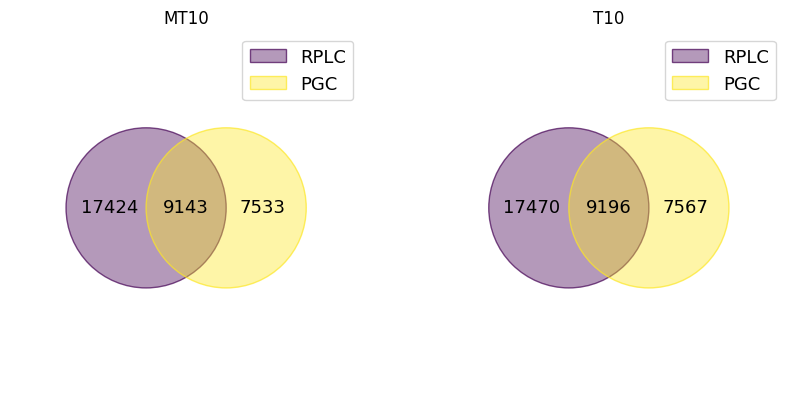

In [146]:
g = df.groupby(['sample', 'column', 'Modified.Sequence']).mean()

samples = df['sample'].unique()
columns = df['column'].unique()

fig, axs = plt.subplots(1, 2, figsize=(10,5))
i = 0
for s in samples:
    overlap = {}
    for c in columns:
        small = g.loc[(s, c), :]
        small.reset_index(inplace=True)
        overlap[c] = set(small["Modified.Sequence"].tolist())
    venn(overlap, ax=axs[i])
    axs[i].set_title(s)

    i += 1

In [ ]:
d = df[(df["Proteotypic"]==1)&(df["Protein.Q.Value"]<=0.01)]
d = d.groupby(['sample', 'column', 'Protein.Ids']).mean()

samples = df['sample'].unique()

fig, axs = plt.subplots(1, 2)
i = 0
for s in samples:
    overlap = {}
    for c in columns:
        small = d.loc[(s, c), :]
        small.reset_index(inplace=True)
        overlap[c] = set(small["Protein.Ids"].tolist())
    venn(overlap, ax=axs[i])
    axs[i].set_title(s)

    i += 1

In [ ]:
d

In [ ]:
alt.Chart(d.reset_index()).mark_area().encode(
    x=alt.X('RT:Q', title='RT',
        bin=alt.Bin(
            step=5
        )),
    y=alt.Y('count():Q', title=''),
    color=alt.Color('column:N'),
    row='sample:N'
)

column_colors = alt.Color('column:N',
    scale=alt.Scale(
        domain=["PGC", "RPLC"],
        range=["#D56E3B", "#58728C"]
    ))
test = d.reset_index()
alt.Chart(test).transform_density(
    'RT',
    as_=['RT', 'density'],
    groupby=['sample', 'column'],
).mark_area(
    opacity=0.6
).encode(
    x=alt.X('RT:Q', title='Retention Time (min)',
        axis=co.alt_axis),
    y=alt.Y('density:Q', title='density',
        axis=co.alt_axis),
    color=column_colors,
    row='sample:N'
).properties(
    height=150,
    width=400
)

In [ ]:
columns = [c.lower().replace('.', '_') for c in df.columns]
df.columns = columns 

In [ ]:
kept_proteins = df[(df["proteotypic"]==1)&(df["protein_q_value"]<=0.01)]

In [ ]:
grouped = df.groupby(['sample', 'column', 'tech_rep', 'protein_ids']).mean()
grouped = grouped.reset_index('protein_ids')
grouped = grouped.sort_index()

samples = ["T10", "MT10"]
columns = ["PGC", "RPLC"]
reps = ["run1", "run2"]

rep_frame = pd.DataFrame()

for s in samples:
    for c in columns:
        d = pd.DataFrame()
        for r in reps:
            small = grouped.loc[(s, c, r), :]
            data = small[['protein_ids', 'pg_maxlfq']]
            data.columns = ['protein_ids', f'{r}_lfq']
            data.loc[:, f'{r}_log2'] = np.log2(data[f'{r}_lfq'])
            data = data.reset_index()
            data = data.drop('tech_rep', axis=1)


            if d.empty:
                d = data 
            else:
                d = d.merge(data, left_on=['protein_ids', 'sample', 'column'], right_on=['protein_ids', 'sample', 'column'])
            
            d.loc[:, 'line_x'] = np.linspace(0,40,len(d))
            d.loc[:, 'line_y'] = d.line_x

        x, y = d.run1_log2, d.run2_log2 
        xy = np.vstack((x, y))
        print(s, c, stats.pearsonr(x, y))
        density = stats.gaussian_kde(xy)(xy)
        d.loc[:, 'density'] = density
        
        rep_frame = pd.concat([rep_frame, d])
        rep_frame = rep_frame.reset_index(drop=True)


In [ ]:
rep_frame

In [ ]:
rplc_rep = alt.Chart(rep_frame).mark_circle(
    size=10
).encode(
    x=alt.X('run1_log2:Q', title='Run 1',
        axis=co.alt_axis,
        scale=alt.Scale(
            domain=[10,30],
            clamp=True
        )),
    y=alt.Y('run2_log2:Q', title='Run 2',
        axis=co.alt_axis,
        scale=alt.Scale(
            domain=[10,30],
            clamp=True
        )),
    color=alt.Color('density:Q',
        scale=alt.Scale(
            range=['#C8CBCF', '#4B6075']
        )),
    # column='sample:N',
).properties(
    width=400,
    height=200
).transform_filter(
    alt.datum.column=='RPLC'
)

pgc_rep = alt.Chart(rep_frame).mark_circle(
    size=10
).encode(
    x=alt.X('run1_log2:Q', title='Rep 1, log2(abundance)',
        axis=co.alt_axis,
        scale=alt.Scale(
            domain=[10,30],
            clamp=True
        )),
    y=alt.Y('run2_log2:Q', title='Rep 2, log2(abundance)',
        axis=co.alt_axis,
        scale=alt.Scale(
            domain=[10,30],
            clamp=True
        )),
    color=alt.Color('density:Q',
        scale=alt.Scale(
            range=['#D2CFCE', '#B65627']
        )),
    # column='sample:N',
).properties(
    width=400,
    height=200
).transform_filter(
    alt.datum.column=='PGC'
)

line = alt.Chart(rep_frame).mark_line(
    strokeDash=[5,3],
    color='#888888'
).encode(
    x=alt.X('line_x:Q',
        scale=alt.Scale(
            domain=[10,30],
            clamp=True
        )),
    y=alt.Y('line_y:Q',
        scale=alt.Scale(
            domain=[10,30],
            clamp=True
        ))
)

# (rplc_rep+line & pgc_rep+line).facet(
#     'sample:N'
# ).resolve_scale(
#     color='independent'
# )

# (line+rplc_rep).facet('sample:N')

((line+rplc_rep).facet('sample:N') & (line+pgc_rep).facet('sample:N')).resolve_scale(
    color='independent'
)

In [ ]:
rep_frame.loc[:, 'difference'] = rep_frame.run1_log2 - rep_frame.run2_log2
rep_frame.loc[:, 'percent_diff'] = abs(rep_frame.difference) / (rep_frame.run1_log2 + rep_frame.run2_log2) / 2 * 100


box = alt.Chart(rep_frame, width=50).mark_boxplot(
    size=40,
    # opacity=0.4
).encode(
    # x='jitter:Q',
    y=alt.Y('percent_diff:Q', title=r"% difference",
        axis=co.alt_axis),
    color='column:N',
    column='sample:N',
    row='column:N'
).transform_calculate(
    jitter='sqrt(-2*log(random()))*cos(2*PI*random())'
)

dens = alt.Chart(rep_frame).mark_area(
    opacity=0.5
).transform_density(
    'percent_diff',
    as_=['percent_diff', 'density'],
    groupby=['sample', 'column']
).encode(
    x=alt.X('percent_diff:Q',
        axis=co.alt_axis,
        scale=alt.Scale(
            domain=[0,2],
            clamp=True
        )),
    y=alt.Y('density:Q', title="density",
        axis=co.alt_axis),
    color='column:N',
    column='sample:N',
    row='column:N'
)
box | dens

In [ ]:
grouped = kept_proteins.groupby(['sample', 'column', 'protein_ids', 'modified_sequence']).mean()
grouped = grouped.reset_index()

counts = grouped.modified_sequence.value_counts()
valid = counts[counts.values==4].keys()
grouped = grouped[grouped.modified_sequence.isin(valid)]
display(grouped[grouped.protein_ids=='P16104'])


grouped = grouped.groupby(['sample', 'column', 'protein_ids']).sum()
grouped

samples = ["MT10", "T10"]
columns = ["PGC", "RPLC"]

protein_comparison = pd.DataFrame()

for s in samples:
    d = pd.DataFrame()
    for c in columns:
        small = grouped.loc[(s, c), :]
        data = small[['ms1_translated']]
        data.columns = [f'{c}_ms1_translated']
        data.loc[:, f'{c}_log2'] = np.log2(data[f'{c}_ms1_translated'])
        # data.loc[:, 'column'] = c
        data.loc[:, 'sample'] = s
        data.reset_index(inplace=True)
        
        if d.empty:
            d = data 
        else:
            d = d.merge(data, left_on=['protein_ids', 'sample'], right_on=['protein_ids', 'sample'])

        d.loc[:, 'line_x'] = np.linspace(0,40,len(d))
        d.loc[:, 'line_y'] = np.linspace(0,40,len(d))

    protein_comparison = pd.concat([protein_comparison, d])
    protein_comparison = protein_comparison.reset_index(drop=True)

In [ ]:
grouped = kept_proteins.groupby(['sample', 'column', 'protein_ids', 'modified_sequence']).mean()
grouped = grouped.reset_index()

grouped.loc[:, 'prot_seq'] = grouped.apply(lambda x: f'{x.protein_ids}_{x.modified_sequence}', axis=1)

counts = grouped.prot_seq.value_counts()
valid = counts[counts.values==4].keys()
grouped = grouped[grouped.prot_seq.isin(valid)]

grouped = grouped.groupby(['sample', 'column', 'protein_ids']).sum()
grouped

samples = ["MT10", "T10"]
columns = ["PGC", "RPLC"]

protein_comparison = pd.DataFrame()

for s in samples:
    d = pd.DataFrame()
    for c in columns:
        small = grouped.loc[(s, c), :]
        data = small[['ms1_translated']]
        data.columns = [f'{c}_ms1_translated']
        data.loc[:, f'{c}_log2'] = np.log2(data[f'{c}_ms1_translated'])
        # data.loc[:, 'column'] = c
        data.loc[:, 'sample'] = s
        data.reset_index(inplace=True)
        
        if d.empty:
            d = data 
        else:
            d = d.merge(data, left_on=['protein_ids', 'sample'], right_on=['protein_ids', 'sample'])

        d.loc[:, 'line_x'] = np.linspace(0,40,len(d))
        d.loc[:, 'line_y'] = np.linspace(0,40,len(d))
    d.replace([np.inf, -np.inf], np.nan, inplace=True)
    d = d.dropna()
    x, y = d.PGC_log2, d.RPLC_log2
    print(stats.pearsonr(x, y))
    xy = np.vstack((x,y))
    density = stats.gaussian_kde(xy)(xy)

    d.loc[:, 'density'] = density

    protein_comparison = pd.concat([protein_comparison, d])
    protein_comparison = protein_comparison.reset_index(drop=True)

In [ ]:
protein_comparison.protein_ids.unique().shape

In [ ]:
line = alt.Chart(protein_comparison).mark_line(
    strokeDash=[5,3],
    color='#888888'
).encode(
    x=alt.X('line_x',
        scale=alt.Scale(
            domain=[15,40],
            clamp=True
        )),
    y=alt.Y('line_y',
        scale=alt.Scale(
            domain=[15,40],
            clamp=True
        ))
)

dots = alt.Chart(protein_comparison).mark_circle(
    color='#7f7f7f',
    size=10,
    # opacity=0.5
).encode(
    x=alt.X('PGC_log2:Q', title='PGC',
        axis=co.alt_axis,
        scale=alt.Scale(
            domain=[15,40],
            clamp=True
        )),
    y=alt.Y('RPLC_log2:Q', title='RPLC',
        axis=co.alt_axis,
        scale=alt.Scale(
            domain=[15,40],
            clamp=True
        )),
    # color=alt.Color('density:Q', legend=None,
    #     scale=alt.Scale(
    #         scheme='greys', 
    #         reverse=True
    #         # range=['#4B6075', '#A1A1A1', '#B65627']
    #     )),
).properties(
    width=300,
    height=200
)

pre_dot_layer = alt.layer(line, dots).facet(
    'sample:N'
).resolve_scale(
    color='independent'
)

box_1 = alt.Chart(protein_comparison, width=150).mark_boxplot(
    color='#7f7f7f',
    size=65
).encode(
    x=alt.X('sample:N',
        axis=co.alt_axis),
    y=alt.Y('difference:Q',
        axis=co.alt_axis)
).transform_calculate(
    difference=alt.datum.RPLC_log2 - alt.datum.PGC_log2
)

# dot_layer | box_1
pre_dot_layer

In [ ]:
taken_columns = ['sample', 'protein_ids', 'ms1_translated']

rplc = kept_proteins[kept_proteins.column=='RPLC']
pgc = kept_proteins[kept_proteins.column=='PGC']
pgc = pgc[~pgc.modified_sequence.isin(rplc.modified_sequence)]


rplc = rplc.groupby(['sample', 'protein_ids'], as_index=False).sum()
left = rplc[taken_columns]

addition = left.copy()
middle = addition[taken_columns]

pgc = pgc.groupby(['sample', 'protein_ids'], as_index=False).sum()
right = pgc[taken_columns]

a = addition.set_index(['sample', 'protein_ids'])
r = right.set_index(['sample', 'protein_ids'])
pgc_sum = a + r
# pgc_sum = pgc_sum.reset_index()

a+r

In [ ]:
left.columns=['sample', 'protein_ids', 'rplc_ms1']
right.columns=['sample', 'protein_ids', 'pgc_ms1']
m = left.merge(right, on=['sample', 'protein_ids'], how='outer').fillna(0)
m.loc[:, 'new_sum'] = (m.rplc_ms1 + m.pgc_ms1)
m.loc[:, 'log_sum'] = np.log2(m.new_sum)

m.loc[:, 'log_rplc'] = np.log2(m.rplc_ms1)
m.loc[:, 'log_pgc'] = np.log2(m.pgc_ms1)

m.loc[:, 'ratio'] = m.new_sum / m.rplc_ms1
m.loc[:, 'log2_sum'] = np.log10(m.new_sum)
alt.Chart(m[(m.rplc_ms1!=0)&(m.pgc_ms1!=0)]).mark_circle(
    size=5
).encode(
    x=alt.X('ratio:Q', title='Ratio',
        scale=alt.Scale(
            domain=[0,2],
            clamp=True)
        ),
    y=alt.Y('log2_sum:Q', title='Log2(sum)'),
    column='sample:N'
)
alt.Chart(m).mark_circle(
    size=5
).encode(
    x=alt.X('log_rplc:Q'),
    y=alt.Y('log_sum:Q'),
    column='sample:N'
)

In [ ]:
left.columns=['sample', 'protein_ids', 'rplc_ms1']
right.columns=['sample', 'protein_ids', 'pgc_ms1']
m = left.merge(right, on=['sample', 'protein_ids'], how='outer').fillna(0)
m.loc[:, 'new_sum'] = m[['rplc_ms1', 'pgc_ms1']].sum(axis=1)
m.loc[:, 'log_sum'] = np.log2(m.new_sum)
m.loc[:, 'log_rplc'] = np.log2(m.rplc_ms1)
m.loc[:, 'log_pgc'] = np.log2(m.pgc_ms1)
m.loc[:, 'ratio'] = m.new_sum / m.rplc_ms1

kept = m[(m.rplc_ms1!=0)&(m.pgc_ms1!=0)]

for sample in ["MT10", "T10"]:
    small = kept[kept['sample'] == sample]
    kept.loc[small.index, 'line_x'] = np.linspace(0, 40, len(small))
    kept.loc[small.index, 'line_y'] = np.linspace(0, 40, len(small))

    x, y = small.log_pgc, small.log_rplc
    print(stats.pearsonr(x, y))
    xy = np.vstack((x, y))
    density = stats.gaussian_kde(xy)(xy)

    kept.loc[small.index, 'density'] = density


x, y = kept.ratio, kept.rplc_ms1
xy = np.vstack((x, y))
dens = stats.gaussian_kde(xy)(xy)

kept.loc[:, 'density'] = dens


alt.Chart(kept[kept.ratio<=5]).mark_circle(
    color='#403f3f',
    size=20
).encode(
    x=alt.X('ratio:Q', title='Ratio',
        scale=alt.Scale(
            domain=[0,5],
            clamp=True)
        ),
    y=alt.Y('log_sum:Q', title='Log2(sum)'),
    column='sample:N',
    # color=alt.Color('density:Q')
)

dots = alt.Chart(kept).mark_circle(
    color='#7f7f7f',
    size=10
).encode(
    x=alt.X('log_rplc:Q',
        scale=alt.Scale(
            domain=[15,40],
            clamp=True
        ),
        axis=co.alt_axis),
    y=alt.Y('log_sum:Q',
        scale=alt.Scale(
            domain=[15,40],
            clamp=True
        ),
        axis=co.alt_axis),
    # column='sample:N'
).properties(
    width=300,
    height=200
)

line = alt.Chart(kept).mark_line(
    strokeDash=[5,3],
    color='#888888'
).encode(
    x=alt.X('line_x',
        scale=alt.Scale(
            domain=[15,40],
            clamp=True
        )),
    y=alt.Y('line_y',
        scale=alt.Scale(
            domain=[15,40],
            clamp=True
        ))
)
post_dot_layer = alt.layer(line, dots).facet('sample:N')

post_dot_layer

In [ ]:
box = alt.Chart(kept, width=150).mark_boxplot(
    color='#7f7f7f',
    size=65
).encode(
    x=alt.X('sample:N',
        axis=co.alt_axis),
    y=alt.Y('difference:Q',
        axis=co.alt_axis)
).transform_calculate(
    difference=alt.datum.log_rplc - alt.datum.log_pgc
)
(box_1 | box).resolve_scale(
    y='shared'
)

In [ ]:
alt.Chart(kept[kept.ratio<=5]).mark_circle(
    # size=20
).encode(
    x=alt.X('ratio:Q', title='Ratio'),
        
    y=alt.Y('log_sum:Q', title='Log2(sum)'),
    column='sample:N',
    # color=alt.Color('density:Q')
)

In [ ]:
kept